In [1]:
%matplotlib inline
from PIL import Image
import numpy
import os
import re
import random
from resizeimage import resizeimage
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.decomposition import PCA
import copy
import matplotlib.image as mpimg
from sklearn.decomposition import RandomizedPCA

In [2]:
import collections
# resize images
def resizeImagesToDest(source, dest, prefix, height, noiseAlgo=None):    
    for root, dirs, files in os.walk(source):
        for name in files:
            if re.match(r'^'+prefix+'.*gif$', name, re.I):
                img = Image.open(os.path.join(source, name))
                (origWidth, origHeight) = img.size
                if (height == origHeight):
                    resizedImg = img
                else:
                    resizedImg = resizeimage.resize_height(img, height)
                
                (width, height) = resizedImg.size
                if noiseAlgo:
                    noisyImg = noiseAlgo(numpy.asarray(resizedImg))
                    Image.fromarray(numpy.uint8(noisyImg.reshape(height,width))).save(dest+name)
                else:
                    resizedImg.save(dest+name)

def resizeImages(source, prefix):
    resizeImagesToDest(source, 'yalefaces_resized/', prefix, 50)
                
# images into array: http://stackoverflow.com/questions/13550376/pil-image-to-array-numpy-array-to-array-python
def readImagesIntoMatrix(path, prefix):
    images = None
    groups = collections.defaultdict(set)
    grouptag = {}
    i = 0
    for root, dirs, files in os.walk(path):
        for name in files:
            if re.match(r'^'+prefix+'.*gif$', name, re.I):
                img = Image.open(path + name)                
                (width, height) = img.size
                imgArr = numpy.asarray(img).reshape(height * width)
                if images is not None:
                    images = numpy.vstack([images, imgArr])
                else:
                    images = imgArr
                group = re.match(r'.*yaleB([0-9]+)_.*', name, re.I).group(1)
                groups[group].add(i)
                grouptag[i] = group
                i += 1
    return images, groups, grouptag

def saveImages(path, images, width, height):
    for i in range(0, len(images)):
        Image.fromarray(numpy.uint8(images[i]).reshape(height, width)).save(path+str(i)+'.gif')
        
def addGaussianNoise(image):
    noisyImage = copy.deepcopy(image)
    mu = noisyImage.mean()
    std = noisyImage.std()
    noise = 0.2 * numpy.random.normal(mu, std, noisyImage.shape)
    for i in range(len(image)):
        for j in range(len(image[0])):
            val = image[i][j]
            if val + noise[i][j] >= 255:
                noisyImage[i][j] = 255
            elif val + noise[i][j] <= 0:
                noisyImage[i][j] = 0
            else:
                noisyImage[i][j] = val + noise[i][j] 
    
    return noisyImage  
    
def addSparseNoise(image):
    noisyImage = copy.deepcopy(image)
    for i in range(len(image)):
        for j in range(len(image[0])):
            rand = random.random()
            if (rand <= 0.01):
                noisyImage[i][j] = 0
    
    return noisyImage

In [3]:
imageList, groups, grouptag = readImagesIntoMatrix('brightyalefaces/', '.*')
imageList = imageList.T

print("Images %s" % imageList)

(width, height) = 168, 192
Image.fromarray(numpy.uint8(imageList.T[0].reshape(height,width))).save("secondyaletest/testsaveimage1.gif")
Image.fromarray(numpy.uint8(imageList.T[100].reshape(height,width))).save("secondyaletest/testsaveimage100.gif")

Images [[ 72   6  55 ...,  51 127  39]
 [ 73   7  59 ...,  58 130  38]
 [ 75   8  65 ...,  59 132  41]
 ..., 
 [ 34 128  60 ...,  20  15  46]
 [ 33 132  55 ...,  16  15  39]
 [ 31 129  48 ...,  12  17  32]]


In [4]:
# average Image
#print('Num images %s' % (imageList.shape,))
avgImg = imageList.mean(axis=1)
print('Average image %s' % (avgImg))
normalizedImageList = imageList - avgImg.reshape(width*height,1)*numpy.ones((1,len(imageList.T)))
Image.fromarray(numpy.uint8(avgImg.reshape(height,width))).save('secondyaletest/avgImg.gif')

Average image [ 57.21857923  59.01457195  61.05919854 ...,  41.61020036  40.18397086
  39.16484517]


In [5]:
def normalize_face(vector):
    minValue = numpy.amin(vector)
    maxValue = numpy.amax(vector)
    scale = (255./(maxValue-minValue))
    return (vector - minValue)*scale

# Fit with PCA for 90% of variance
pca = PCA(0.9).fit_transform(normalizedImageList)
print('With PCA there were %s eigenfaces that captures 90pct of the variance' % len(pca.T))

for i in range(len(pca.T)):
    eigv = pca[:,i].reshape(1,width * height).T
    eigenface = normalize_face(eigv)
    Image.fromarray(numpy.uint8(eigenface.reshape(height,width))).save('secondyaletest/trial2-eigenface%s.gif' % i)

With PCA there were 42 eigenfaces that captures 90pct of the variance


In [6]:
from numpy.linalg import norm, svd
from scipy.io import loadmat, savemat

def inexact_augmented_lagrange_multiplier(X, lmbda=.01, tol=1e-3,
                                          maxiter=100, verbose=True):
    """
    Inexact Augmented Lagrange Multiplier
    """
    Y = X
    norm_two = norm(Y.ravel(), 2)
    norm_inf = norm(Y.ravel(), numpy.inf) / lmbda
    dual_norm = numpy.max([norm_two, norm_inf])
    Y = Y / dual_norm
    A = numpy.zeros(Y.shape)
    E = numpy.zeros(Y.shape)
    dnorm = norm(X, 'fro')
    mu = 1.25 / norm_two
    rho = 1.5
    sv = 10.
    n = Y.shape[0]
    itr = 0
    while True:
        if verbose:
            print('Iterations %s' % itr)
        Eraw = X - A + (1 / mu) * Y
        Eupdate = numpy.maximum(Eraw - lmbda / mu, 0) + numpy.minimum(Eraw + lmbda / mu, 0)
        U, S, V = svd(X - Eupdate + (1 / mu) * Y, full_matrices=False)
        svp = (S > 1 / mu).shape[0]
        if svp < sv:
            sv = numpy.min([svp + 1, n])
        else:
            sv = numpy.min([svp + round(.05 * n), n])
        Aupdate = numpy.dot(numpy.dot(U[:, :svp], numpy.diag(S[:svp] - 1 / mu)), V[:svp, :])
        A = Aupdate
        E = Eupdate
        Z = X - A - E
        Y = Y + mu * Z
        mu = numpy.min([mu * rho, mu * 1e7])
        itr += 1
        if ((norm(Z, 'fro') / dnorm) < tol) or (itr >= maxiter):
            break
    if verbose:
        print("Finished at iteration %d" % (itr))  
    return A,E

In [7]:
A, E = inexact_augmented_lagrange_multiplier(normalizedImageList, lmbda=0.01)

Iterations 0
Iterations 1
Iterations 2
Iterations 3
Iterations 4
Iterations 5
Iterations 6
Iterations 7
Iterations 8
Iterations 9
Iterations 10
Iterations 11
Iterations 12
Iterations 13
Iterations 14
Iterations 15
Iterations 16
Iterations 17
Iterations 18
Finished at iteration 19


In [8]:
A2, E2 = inexact_augmented_lagrange_multiplier(normalizedImageList, lmbda=0.005)

Iterations 0
Iterations 1
Iterations 2
Iterations 3
Iterations 4
Iterations 5
Iterations 6
Iterations 7
Iterations 8
Iterations 9
Iterations 10
Iterations 11
Iterations 12
Iterations 13
Iterations 14
Iterations 15
Iterations 16
Iterations 17
Iterations 18
Iterations 19
Iterations 20
Iterations 21
Iterations 22
Iterations 23
Iterations 24
Iterations 25
Iterations 26
Finished at iteration 27


In [9]:
A3, E3 = inexact_augmented_lagrange_multiplier(normalizedImageList, lmbda=0.02)

Iterations 0
Iterations 1
Iterations 2
Iterations 3
Iterations 4
Iterations 5
Iterations 6
Iterations 7
Iterations 8
Iterations 9
Iterations 10
Iterations 11
Iterations 12
Iterations 13
Iterations 14
Iterations 15
Iterations 16
Iterations 17
Finished at iteration 18


In [10]:
A4, E4 = inexact_augmented_lagrange_multiplier(normalizedImageList, lmbda=0.001)

Iterations 0
Iterations 1
Iterations 2
Iterations 3
Iterations 4
Iterations 5
Iterations 6
Iterations 7
Iterations 8
Iterations 9
Iterations 10
Iterations 11
Iterations 12
Iterations 13
Iterations 14
Iterations 15
Iterations 16
Iterations 17
Iterations 18
Iterations 19
Iterations 20
Iterations 21
Iterations 22
Iterations 23
Iterations 24
Iterations 25
Iterations 26
Iterations 27
Finished at iteration 28


In [11]:
Image.fromarray(numpy.uint8((A.T[0] + avgImg).reshape(height,width))).save("secondyaletest/testsaveimage1afterrpca.gif")

print('Error %s' % E)
print('Error %s' % E2)

print('Relative error %s %s' % (0.01, numpy.linalg.norm(E, 'fro')/numpy.linalg.norm(normalizedImageList, 'fro')))
print('Relative error %s %s' % (0.005, numpy.linalg.norm(E2, 'fro')/numpy.linalg.norm(normalizedImageList, 'fro')))
print('Relative error %s %s' % (0.2, numpy.linalg.norm(E3, 'fro')/numpy.linalg.norm(normalizedImageList, 'fro')))
print('Relative error %s %s' % (0.001, numpy.linalg.norm(E4, 'fro')/numpy.linalg.norm(normalizedImageList, 'fro')))

Error [[ 0.          0.          0.         ...,  0.          0.12038401  0.        ]
 [ 0.          0.          0.         ...,  0.          0.07354871  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 1.50842891  0.          0.         ...,  0.          0.          0.        ]
 [ 0.26279211  0.          0.         ...,  0.          0.         -0.27934687]
 [ 0.          0.          0.         ...,  0.          0.         -2.11525018]]
Error [[  3.67621382  12.38032756  -0.72297368 ...,  -8.24273161  16.26121877
   -0.8139811 ]
 [  0.98216544  11.45862042   0.06517138 ...,  -5.28928933  16.80629905
   -2.86680908]
 [  1.45067419   9.21796342   0.08885916 ...,  -4.86704341  14.32996968
   -0.86591037]
 ..., 
 [  8.16000819  -0.3223624    1.44724306 ...,  -8.61998214   1.17230131
    8.71218903]
 [  7.62326722   2.18602723   3.19860386 ...,  -7.18135537   0.40203718
    3.15543335]
 [  5.46823086   1.76319071   1.61599206 ...,  -5.442

In [12]:

# Fit with PCA for 90% of variance
rpca = PCA(0.9).fit_transform(A)
rpca2 = PCA(0.9).fit_transform(A2)
rpca4 = PCA(0.9).fit_transform(A4)

print('After RPCA (lam=%s) there were %s eigenfaces that captures 90pct of the variance' % (0.01, len(rpca.T)))
print('After RPCA (lam=%s) there were %s eigenfaces that captures 90pct of the variance' % (0.005, len(rpca2.T)))
print('After RPCA (lam=%s) there were %s eigenfaces that captures 90pct of the variance' % (0.001, len(rpca4.T)))

#Let's make images for the same number of eigenfaces we used originally
rpca = PCA(len(pca.T)).fit_transform(A)
rpca2 = PCA(len(pca.T)).fit_transform(A2)
rpca3 = PCA(len(pca.T)).fit_transform(A3)
rpca4 = PCA(len(pca.T)).fit_transform(A4)

After RPCA (lam=0.01) there were 33 eigenfaces that captures 90pct of the variance
After RPCA (lam=0.005) there were 16 eigenfaces that captures 90pct of the variance
After RPCA (lam=0.001) there were 1 eigenfaces that captures 90pct of the variance


In the original dimension silhouette is 0.0268622427505
Clustering silhouette over PCA [-0.23624407024625071, -0.21523710474392357, -0.18315982503087153, -0.14859237053420382, -0.1174162937472847, -0.095934918670641661, -0.078254696885158612, -0.067775997298390789, -0.052482360921126563, -0.046042205827344543, -0.035009943115803098, -0.029458012278270457, -0.024521490876526494, -0.019234238495167071, -0.015044827446019862, -0.010779649012717147, -0.0059046322018563432, -0.0019980219380593611, 0.0010355456038692085, 0.0029167862931912636, 0.004172634015401664, 0.0063918274576653172, 0.0082946956096369134, 0.0093520857789351555, 0.010932008569935054, 0.013071523063492232, 0.014951401830714443, 0.016140980816282569, 0.017554979518574178, 0.018457921380543581, 0.019753227894337581, 0.020401349076911393, 0.020851822623917861, 0.02174249977109249, 0.023036769611266814, 0.024499053899174329, 0.026718255195639286, 0.027294576310576558, 0.028084453091962818, 0.029073487637909581, 0.029494350002

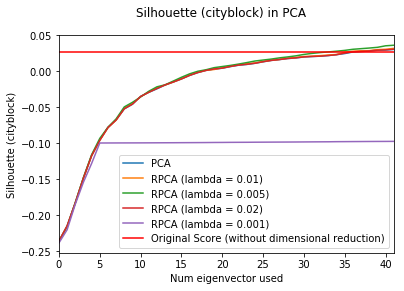

In the original dimension silhouette is 0.0703100408698
Clustering silhouette over PCA [-0.23624407024625071, -0.21523710474392357, -0.18315982503087153, -0.14859237053420382, -0.1174162937472847, -0.095934918670641661, -0.078254696885158612, -0.067775997298390789, -0.052482360921126563, -0.046042205827344543, -0.035009943115803098, -0.029458012278270457, -0.024521490876526494, -0.019234238495167071, -0.015044827446019862, -0.010779649012717147, -0.0059046322018563432, -0.0019980219380593611, 0.0010355456038692085, 0.0029167862931912636, 0.004172634015401664, 0.0063918274576653172, 0.0082946956096369134, 0.0093520857789351555, 0.010932008569935054, 0.013071523063492232, 0.014951401830714443, 0.016140980816282569, 0.017554979518574178, 0.018457921380543581, 0.019753227894337581, 0.020401349076911393, 0.020851822623917861, 0.02174249977109249, 0.023036769611266814, 0.024499053899174329, 0.026718255195639286, 0.027294576310576558, 0.028084453091962818, 0.029073487637909581, 0.029494350002

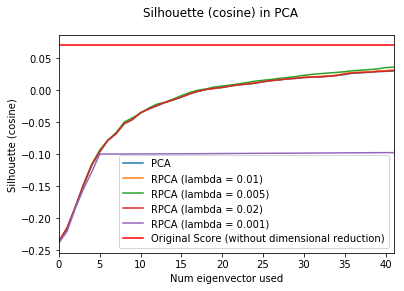

In the original dimension silhouette is 0.0439600169583
Clustering silhouette over PCA [-0.23624407024625071, -0.21523710474392357, -0.18315982503087153, -0.14859237053420382, -0.1174162937472847, -0.095934918670641661, -0.078254696885158612, -0.067775997298390789, -0.052482360921126563, -0.046042205827344543, -0.035009943115803098, -0.029458012278270457, -0.024521490876526494, -0.019234238495167071, -0.015044827446019862, -0.010779649012717147, -0.0059046322018563432, -0.0019980219380593611, 0.0010355456038692085, 0.0029167862931912636, 0.004172634015401664, 0.0063918274576653172, 0.0082946956096369134, 0.0093520857789351555, 0.010932008569935054, 0.013071523063492232, 0.014951401830714443, 0.016140980816282569, 0.017554979518574178, 0.018457921380543581, 0.019753227894337581, 0.020401349076911393, 0.020851822623917861, 0.02174249977109249, 0.023036769611266814, 0.024499053899174329, 0.026718255195639286, 0.027294576310576558, 0.028084453091962818, 0.029073487637909581, 0.029494350002

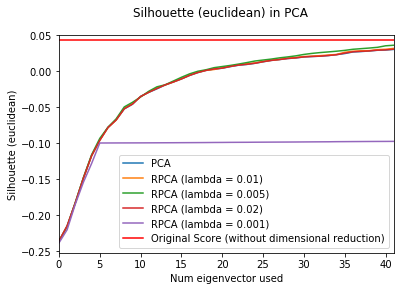

In [13]:
xdata = [0.0]*len(pca.T)
ydata = [0.0]*len(pca.T)
ydataRPCA = [0.0]*len(pca.T)
ydataRPCA2 = [0.0]*len(pca.T)
ydataRPCA3 = [0.0]*len(pca.T)
ydataRPCA4 = [0.0]*len(pca.T)

from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score

pca_normalized = normalize(pca, axis=0, norm='l2')
rpca_normalized = normalize(rpca, axis=0, norm='l2')
rpca2_normalized = normalize(rpca2, axis=0, norm='l2')
rpca3_normalized = normalize(rpca3, axis=0, norm='l2')
rpca4_normalized = normalize(rpca4, axis=0, norm='l2')

grouptagarray = [""]*len(grouptag)
for i in range(len(grouptag)):
    grouptagarray[i] = grouptag[i]

for metric in ['cityblock', 'cosine', 'euclidean']:
    original_clustering = silhouette_score(normalizedImageList.T, grouptagarray, metric=metric)
    print('In the original dimension silhouette is %s' % original_clustering)

    for i in range(len(pca.T)):
      xdata[i] = i
      projected = normalizedImageList.T.dot(pca_normalized[:,:i+1])
      ydata[i] = silhouette_score(projected, grouptagarray)
    
      # lambda = 0.01
      projectedRPCA = normalizedImageList.T.dot(rpca_normalized[:,:i+1])
      ydataRPCA[i] = silhouette_score(projectedRPCA, grouptagarray)
    
      # lambda = 0.005
      projectedRPCA2 = normalizedImageList.T.dot(rpca2_normalized[:,:i+1])
      ydataRPCA2[i] = silhouette_score(projectedRPCA2, grouptagarray)
    
      # lambda = 0.02
      projectedRPCA3 = normalizedImageList.T.dot(rpca3_normalized[:,:i+1])
      ydataRPCA3[i] = silhouette_score(projectedRPCA3, grouptagarray)
    
      # lambda = 0.001
      projectedRPCA4 = normalizedImageList.T.dot(rpca4_normalized[:,:i+1])
      ydataRPCA4[i] = silhouette_score(projectedRPCA4, grouptagarray)

    print('Clustering silhouette over PCA %s' % ydata)

    fig = plt.figure()
    fig.suptitle("Silhouette (%s) in PCA" % metric)
    plt.plot(xdata, ydata, label="PCA")
    plt.plot(xdata, ydataRPCA, label="RPCA (lambda = 0.01)")
    plt.plot(xdata, ydataRPCA2, label="RPCA (lambda = 0.005)")
    plt.plot(xdata, ydataRPCA3, label="RPCA (lambda = 0.02)")
    plt.plot(xdata, ydataRPCA4, label="RPCA (lambda = 0.001)")
    plt.axhline(y=original_clustering, color='r', linestyle='-', label='Original Score (without dimensional reduction)')
    plt.xlabel("Num eigenvector used")
    plt.ylabel("Silhouette (%s)" % metric)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.legend()
    plt.savefig("figures/rpcatrial2%s.png" % metric, format = 'png')
    plt.show()
    plt.close()


In [15]:
imagesH = None
rpcaImagesH = None
rpcaImagesH2 = None
rpcaImagesH3 = None

count = 0
for i in groups["24"]:
    if count > 5:
        break
    if imagesH is None:
        imagesH = imageList.T[i].reshape(height,width)
    else:
        imagesH = numpy.hstack([imagesH, imageList.T[i].reshape(height,width)])
    if rpcaImagesH is None:
        rpcaImagesH = (A.T[i] + avgImg).reshape(height,width)
    else:
        rpcaImagesH = numpy.hstack([rpcaImagesH, (A.T[i] + avgImg).reshape(height,width)])
    if rpcaImagesH2 is None:
        rpcaImagesH2 = (A2.T[i] + avgImg).reshape(height,width)
    else:
        rpcaImagesH2 = numpy.hstack([rpcaImagesH2, (A2.T[i] + avgImg).reshape(height,width)])
    if rpcaImagesH3 is None:
        rpcaImagesH3 = (A4.T[i] + avgImg).reshape(height,width)
    else:
        rpcaImagesH3 = numpy.hstack([rpcaImagesH3, (A4.T[i] + avgImg).reshape(height,width)])
    count += 1
    
def removeOutliers(array):
    for i in range(len(array)):
        for j in range(len(array[0])):
            if array[i][j] > 255:
                array[i][j] = 255
            elif array[i][j] < 0:
                array[i][j] = 0
    return array
    
Image.fromarray(numpy.uint8(imagesH)).save("figures/person24trial2.gif")
Image.fromarray(numpy.uint8(removeOutliers(rpcaImagesH))).save("figures/person24Afterl=0dot01RPCAtrial2.gif")
Image.fromarray(numpy.uint8(removeOutliers(rpcaImagesH2))).save("figures/person24Afterl=0dot005RPCAtrial2.gif")
Image.fromarray(numpy.uint8(removeOutliers(rpcaImagesH3))).save("figures/person24Afterl=0dot001RPCAtrial2.gif")